# Capstone Project: Saudi Arabia Historical Climate Data - Machine Learning
# By Using GridSearch

**SDA Data Science Bootcamp** <br>
**By Yasmeen Aldossary, Nourah Al-Mutlaq, Halah Almodarra and Abdullah Alhussain**<br>
**15 July 2021**

In [1]:
# Importing required libraries
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [3]:
# Load Dataset
df = pd.read_csv("https://raw.githubusercontent.com/Yasmeenmad/data_science_bootcamp/main/Capstone_Project/Datasets/saudi_arabia_weather_history.csv")
# Display the top 5 rows
df.head()

,Unnamed: 0,city,date,time,year,month,day,hour,minute,weather,temp,wind,humidity,barometer,visibility
0,0,Qassim,1 January 2017,00:00,2017,1,1,24,0,Clear,17,11,64%,1018.0,16
1,1,Qassim,1 January 2017,01:00,2017,1,1,1,0,Clear,17,6,64%,1018.0,16
2,2,Qassim,1 January 2017,03:00,2017,1,1,3,0,Clear,15,11,72%,1019.0,16
3,3,Qassim,1 January 2017,04:00,2017,1,1,4,0,Clear,15,11,72%,1019.0,16
4,4,Qassim,1 January 2017,05:00,2017,1,1,5,0,Clear,15,9,72%,1019.0,16


In [4]:
# Finding the null values
df.isnull().sum()

Unnamed: 0     0
city           0
date           0
time           0
year           0
month          0
day            0
hour           0
minute         0
weather        0
temp           0
wind           0
humidity      17
barometer     72
visibility     0
dtype: int64

In [5]:
df = df.fillna(method='ffill').fillna(method='bfill')
# Check 
df.isnull().sum()

Unnamed: 0    0
city          0
date          0
time          0
year          0
month         0
day           0
hour          0
minute        0
weather       0
temp          0
wind          0
humidity      0
barometer     0
visibility    0
dtype: int64

In [6]:
# Rename 'EP' city
df['city'] = df['city'].replace('EP', 'Eastern Province')
cities = ['Assir', 'Eastern Province', 'Riyadh']
df = df.loc[~df['city'].isin(cities)]

In [7]:
# Remove the (%) form the 'humidity' column, then Divide values by 100
# Convert the 'humidity' column to int
df['humidity'] = df['humidity'].str.replace(r'\D', '')
df['humidity'] = df['humidity'].astype(int)
df['humidity'] = df['humidity']/100

In [8]:
# create a function to attribute each month to its season
def seasons(df):
    # winter season: Mid-December to Mid-March
    if df['month'] in range(1, 4):
        return ('winter')
    # spring season: Mid-March to Mid-June
    elif df['month'] in range(4, 7):
        return ('spring')
    # summer season: Mid-June to Mid-September
    elif df['month'] in range(7, 10):
        return ('summer')
    # autumn season: Mid-September to Mid-December
    else:
        return ('autumn')
    
# create the season column
df['season'] = df.apply(seasons, axis = 1)

In [9]:
# create a function to classify the values in 'weather' column 
def weather_cleaning(col):
    # Weather conditions that refers to Mostly clear in 'weather' column
    Mostly_clear = ['Broken clouds ', 'Passing clouds ', 'Rain  Clear ']
    # Weather conditions that refers to Partly cloudy in 'weather' column
    Partly_cloudy = ['Partly sunny ', 'Drizzle  More clouds than sun ', 'Thunderstorms  Partly sunny ',
                     'Thunderstorms  Scattered clouds ', 'Light rain  More clouds than sun ', 'Light rain  Partly cloudy ',
                     'Light rain  Scattered clouds ', 'Low level haze ', 'More clouds than sun ', 'Rain  Broken clouds ',
                     'Rain  Partly cloudy ', 'Scattered clouds', 'Rain  Scattered clouds','Sprinkles  Cloudy', 
                     'Thundershowers  Partly sunny ', 'Drizzle  Partly sunny ', 'Thundershowers  Passing clouds ', 
                     'Thundershowers  Scattered clouds ', 'Thunderstorms  Broken clouds ', 'Thunderstorms  Partly cloudy ', 
                     'Thunderstorms  Partly sunny ', 'Thunderstorms  Passing clouds ', 'Heavy rain  Partly sunny ', 
                     'Light rain  Partly sunny ', 'Light rain  Passing clouds ', 'Rain  Passing clouds ',
                     'Thunderstorms  Scattered clouds ', 'Rain  Partly sunny ','Rain showers  Partly sunny ']
    # Weather conditions that refers to Prevailingly cloudy in 'weather' column
    Prevailingly_cloudy = ['Cloudy ', 'Drizzle  More clouds than sun ', 'Drizzle  Mostly cloudy ', 'Fog ', 'Hail  Partly sunny ',
                           'Drizzle  Broken clouds ', 'Hail  Passing cloud ', 'Haze', 'Heavy rain  More clouds than sun ',
                           'Heavy rain  Mostly cloudy ', 'Light rain  Broken clouds ', 'Light rain  Fog ', 
                           'Light rain  Mostly cloudy ', 'Mostly cloudy ', 'Rain  More clouds than sun ','Rain  Mostly cloudy ',
                           'Sprinkles  Duststorm ', 'Sprinkles  Low level haze ', 'Strong thunderstorms  More clouds than sun ',
                           'Thunderstorms  Passing clouds ', 'Strong thunderstorms  Partly sunny ', 'Thundershowers  Partly sunny ',
                           'Thunderstorms  Cloudy ', 'Thunderstorms  Fog ', 'Thunderstorms  More clouds than sun ', 
                           'Thunderstorms  Mostly cloudy ']
    # Weather conditions that refers to Overcast in 'weather' column
    Overcast = ['Hail  Cloudy ', 'Dense fog ', 'Rain  Overcast ', 'Thunderstorms  Overcast ', 'Light rain  Overcast ', 
                'Drizzle  Overcast ', 'Sprinkles  Overcast ', 'Thunderstorms  Sandstorm ', 'Drizzle  Dense fog ',
                'Drizzle  Fog ', 'Drizzle  Overcast ', 'Duststorm ', 'Light rain  Overcast ', 'Rain  Fog ',
                'Rain  Sandstorm ', 'Sandstorm ', 'Strong thunderstorms  Cloudy ', 'Thunderstorms  Sandstorm ']
    # Weather conditions that refers to Overcast heavy rain in 'weather' column
    Overcast_heavy_rain = ['Heavy rain  Overcast ']
    
    # initial empty lists
    weather = []
    
    # for-loop to iterate through the whole dataset 
    for x in range(len(col)):
        # if the value of 'weather' column in this list then appand 'Mostly Clear'
        if col.iloc[x] in Mostly_clear:
            weather.append('Mostly Clear')
        
        # if the value of 'weather' column in this list then appand 'Partly Cloudy'
        elif col.iloc[x] in Partly_cloudy:
            weather.append('Partly Cloudy')
        
        # if the value of 'weather' column in this list then appand 'Prevailingly Cloudy'    
        elif col.iloc[x] in Prevailingly_cloudy:
            weather.append('Prevailingly Cloudy')
        
        # if the value of 'weather' column in this list then appand 'Overcast'
        elif col.iloc[x] in Overcast:
            weather.append('Overcast')
        
        # if the value of 'weather' column in this list then appand 'Overcast Heavy Rain'
        elif col.iloc[x] in Overcast_heavy_rain:
            weather.append('Overcast Heavy Rain')
        
        # else appand 'Clear'
        else:
            weather.append('Clear')
    
    # return the list
    return weather

# Assign the weather list to a new column named 'weather_category'
df['weather_category'] = weather_cleaning(df['weather'])

# drop unused column
df = df.drop(['weather'], axis = 1)
# Display 5 random rows
df.sample(5)

,Unnamed: 0,city,date,time,year,month,day,hour,minute,temp,wind,humidity,barometer,visibility,season,weather_category
117994,117994,Tabuk,3 May 2017,12:00,2017,5,3,12,0,28,7,0.16,1013.0,16,spring,Clear
181694,181694,Jazan,29 June 2018,06:00,2018,6,29,6,0,21,7,0.20,1018.0,2,spring,Clear
8768,8768,Qassim,9 January 2018,15:00,2018,1,9,15,0,18,19,0.30,1027.0,16,winter,Clear
212478,212478,Baha,9 June 2017,18:00,2017,6,9,18,0,35,19,0.11,1016.0,-1,spring,Mostly Clear
47837,47837,Madina,1 December 2017,14:00,2017,12,1,14,0,26,13,0.32,1018.0,16,autumn,Clear


In [10]:
# Split Data to training (80%) and testing (20%)
train, test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state=42)

In [11]:
# OrdinalEncoder is for encode categorical features as an integer array 
# Create our Ordinal Encoder object
ordinal = OrdinalEncoder()

# The categorical features
columns_to_enc = ['season', 'year', 'month', 'day', 'hour', 'minute']

# Ordinal encode the columns
ordinal_train = ordinal.fit_transform(train[columns_to_enc])
ordinal_test = ordinal.transform(test[columns_to_enc])

# Convert ordinal_train and ordinal_test to a dataframes
train_ordinal = pd.DataFrame(ordinal_train, columns = columns_to_enc)
test_ordinal = pd.DataFrame(ordinal_test, columns = columns_to_enc)

In [12]:
# StandardScaler is for standardize features by removing the mean and scaling to unit variance
# Create our Standard Scaler object
scaler = StandardScaler()

# Features that need to Scale
columns_to_scale = ['temp', 'wind', 'humidity', 'barometer', 'visibility']

# Standard Scaling the columns
scaled_train = scaler.fit_transform(train[columns_to_scale])
scaled_test = scaler.transform(test[columns_to_scale])

# Convert scaled_train and scaled_test to a dataframes
train_scaled = pd.DataFrame(scaled_train, columns = columns_to_scale)
test_scaled = pd.DataFrame(scaled_test, columns = columns_to_scale)

In [13]:
# OneHotEncoder is for encode categorical features as a one-hot numeric array
# Create our One Hot Encoder object
one_hot = OneHotEncoder()

# Features that need to One Hot encode
columns_to_onehot = ['city', 'weather_category']

# One Hot encode the columns
one_hot_train = one_hot.fit_transform(train[columns_to_onehot]).toarray()
one_hot_test = one_hot.transform(test[columns_to_onehot]).toarray()

# The new column names after One Hot encode
column_names = ['city_Baha', 'city_Hail', 'city_Jawf', 'city_Jazan', 'city_Madina', 'city_Mecca', 'city_Najran',
                'city_Northern boarder', 'city_Qassim', 'city_Tabuk', 'weather_category_Clear', 'weather_category_Mostly Clear',
                'weather_category_Overcast', 'weather_category_Partly Cloudy', 'weather_category_Prevailingly Cloudy']

# Convert one_hot_train and one_hot_test to a dataframes
train_one_hot = pd.DataFrame(one_hot_train, columns = column_names)
test_one_hot = pd.DataFrame(one_hot_test, columns = column_names)

In [14]:
# Add a new column to all these dataset which is there index
# To be able to merge these dataframes
train_ordinal['index'] = train_ordinal.index
test_ordinal['index'] = test_ordinal.index
train_scaled['index'] = train_scaled.index
test_scaled['index'] = test_scaled.index
train_one_hot['index'] = train_one_hot.index
test_one_hot['index'] = test_one_hot.index

In [15]:
trains = [train_ordinal, train_scaled, train_one_hot] # all train dataframes that we have created
tests  = [test_ordinal, test_scaled, test_one_hot]    # all test dataframes that we have created

# merage all the train and together by 'index' column, then merage the test dataframes
train = reduce(lambda left,right: pd.merge(left,right,on='index'), trains) 
test = reduce(lambda left,right: pd.merge(left,right,on='index'), tests)

# First: Predict the temperature

In [15]:
# The column that we will predict
target = "temp"

X_train_temp = train.drop(target, axis=1) # features
y_train_temp = train[target] # target

X_test_temp = test.drop(target, axis=1) # features
y_test_temp = test[target] # target

# KNN Model

In [16]:
# define the model
model_KNN1 = KNeighborsRegressor()
model_KNN1.fit(X_train_temp, y_train_temp)
# predict the temperature
preds_KNN1 = model_KNN1.predict(X_train_temp) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_temp, preds_KNN1))
print ("Testing MAE",  mean_absolute_error(y_test_temp, model_KNN1.predict(X_test_temp)))

Training MAE 0.67021423657234
Testing MAE 0.8333809131937672


In [17]:
mae_val = [] #to store mae values for different k
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_temp, y_train_temp)  #fit the model
    pred = model.predict(X_test_temp) # make prediction on test set
    error = mean_absolute_error(y_test_temp,pred) 
    mae_val.append(error) #store mae values
    print('mae value for k= ' , K , 'is:', error) 

mae value for k=  1 is: 0.9769152592330266
mae value for k=  2 is: 0.8771206196535816
mae value for k=  3 is: 0.8490903433226824
mae value for k=  4 is: 0.8368285023134557
mae value for k=  5 is: 0.8333809131937672
mae value for k=  6 is: 0.8299075678391449
mae value for k=  7 is: 0.8295532021860422
mae value for k=  8 is: 0.8275204331559592
mae value for k=  9 is: 0.826561910970437
mae value for k=  10 is: 0.8257782345955167
mae value for k=  11 is: 0.8257666889907003
mae value for k=  12 is: 0.8255112126835301
mae value for k=  13 is: 0.8254789723614799
mae value for k=  14 is: 0.8252301686758493
mae value for k=  15 is: 0.8254032238148801
mae value for k=  16 is: 0.8255816911082126
mae value for k=  17 is: 0.8257998202486655
mae value for k=  18 is: 0.8260703571291845
mae value for k=  19 is: 0.8259044081054434
mae value for k=  20 is: 0.825847073987067


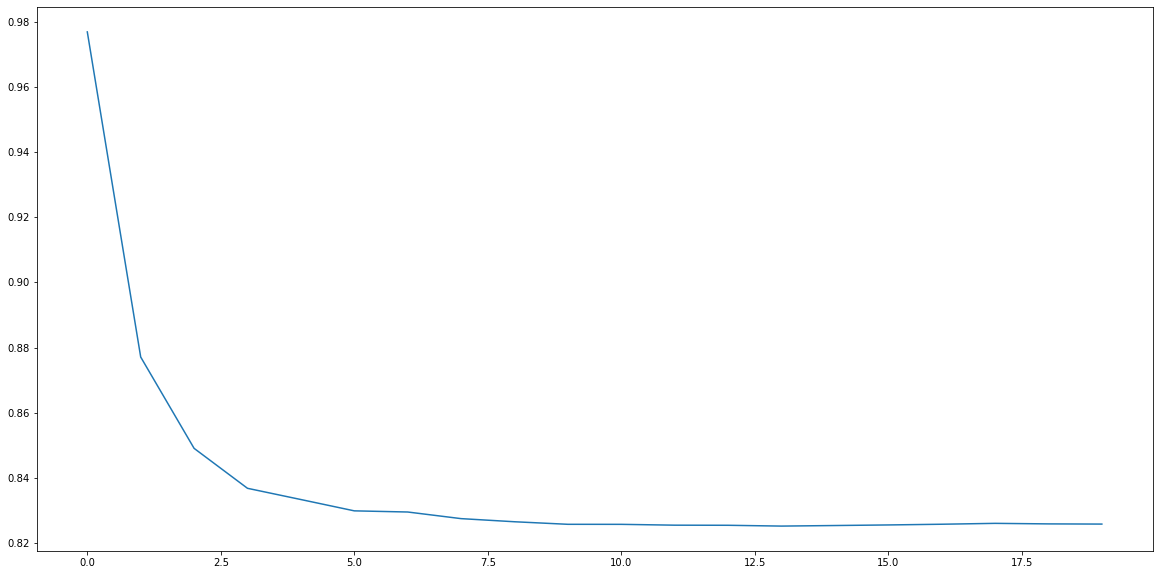

In [18]:
# plotting the mae values against k values
plt.figure(figsize = (20 , 10))
curve = pd.DataFrame(mae_val) # elbow curve 
plt.plot(curve)
#curve.plot()
plt.show()

In [19]:
# define the model
model_KNN2 = KNeighborsRegressor(n_neighbors = 14)
model_KNN2.fit(X_train_temp, y_train_temp)
# predict the temperature
preds_KNN2 = model_KNN2.predict(X_train_temp) 
# evaluate the model
print ("Training MAE",mean_absolute_error(y_train_temp, preds_KNN2))
print ("Testing MAE", mean_absolute_error(y_test_temp, model_KNN2.predict(X_test_temp)))

Training MAE 0.7647438738755162
Testing MAE 0.8252301686758493


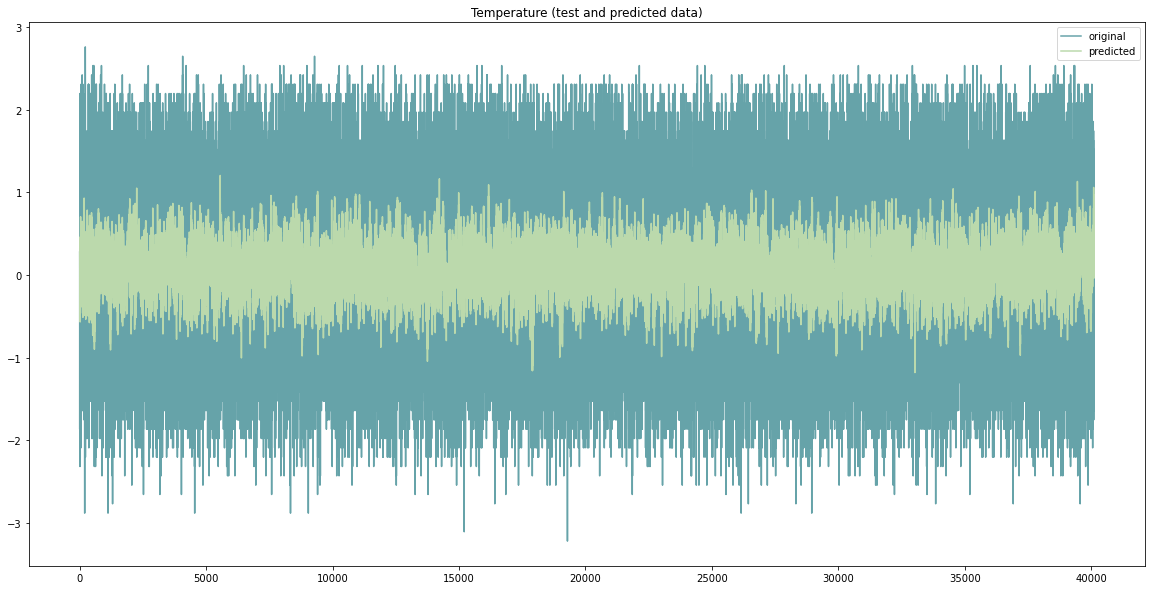

In [27]:
y_pred_temp = model_KNN2.predict(X_test_temp)
x_ax = range(len(y_test_temp))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_temp, label="original", color='#66a3a9')
plt.plot(x_ax, y_pred_temp, label="predicted", color='#bbd9ac')
plt.title("Temperature (test and predicted data)")
plt.legend()
plt.show()

# XGBoost Model

In [28]:
# define the model
model_XGB = XGBRegressor()
model_XGB.fit(X_train_temp, y_train_temp)
# predict the temperature
preds_XGB = model_XGB.predict(X_train_temp) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_temp, preds_XGB))
print ("Testing MAE", mean_absolute_error(y_test_temp, model_XGB.predict(X_test_temp)))

Training MAE 0.13089013106892636
Testing MAE 0.13552277700283386


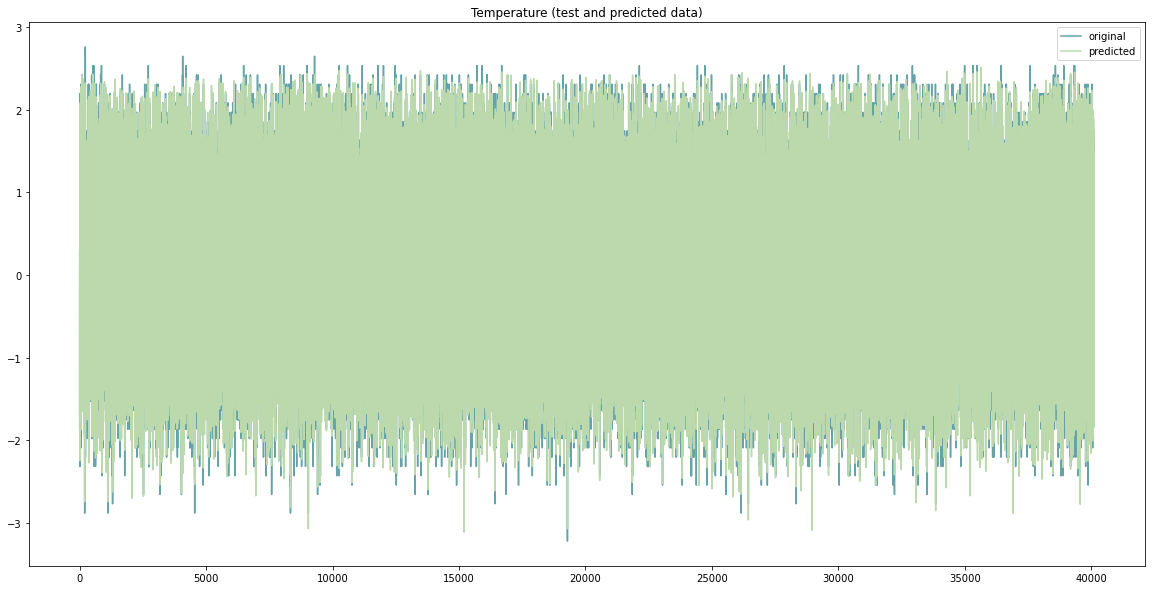

In [30]:
y_pred_temp = model_XGB.predict(X_test_temp)
x_ax = range(len(y_test_temp))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_temp, label="original", color='#66a3a9')
plt.plot(x_ax, y_pred_temp, label="predicted", color='#bbd9ac')
plt.title("Temperature (test and predicted data)")
plt.legend()
plt.show()

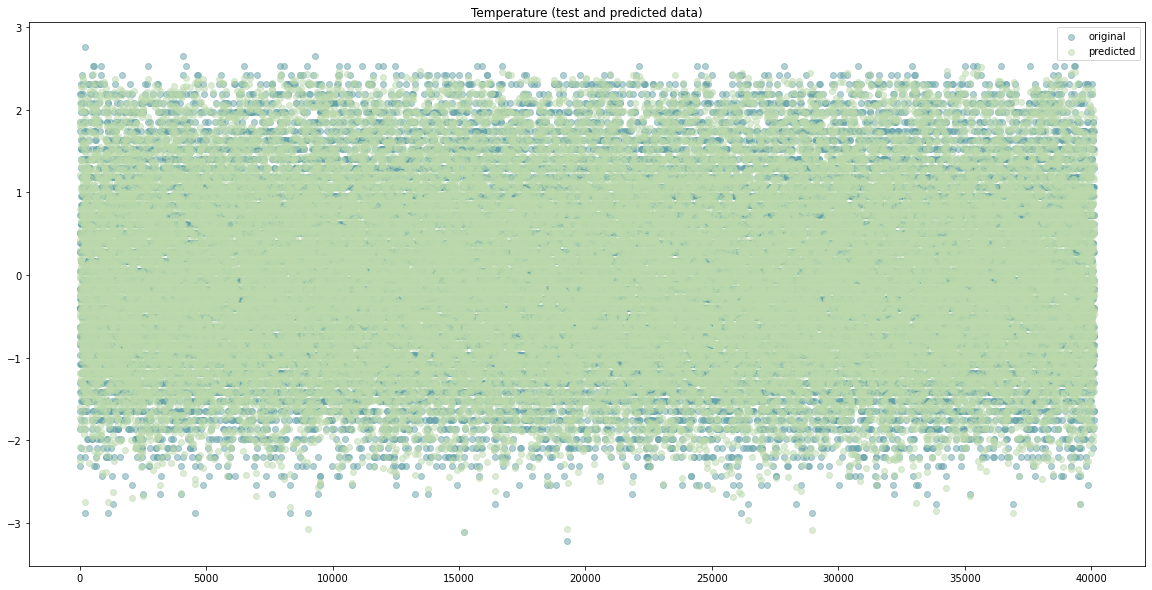

In [31]:
y_pred_temp = model_XGB.predict(X_test_temp)
x_ax = range(len(y_test_temp))
plt.figure(figsize = (20 , 10))
plt.scatter(x_ax, y_test_temp, label="original", color='#66a3a9', alpha=0.5)
plt.scatter(x_ax, y_pred_temp, label="predicted", color='#bbd9ac',alpha=0.5 )
plt.title("Temperature (test and predicted data)")
plt.legend(loc='best')
plt.show()

In [16]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror'] }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [17]:
hyperParameterTuning(X_train_temp, y_train_temp)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 127.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 240.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 409.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 513.2min finished


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [18]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.1,
        max_depth = 10,
        min_child_weight = 3,
        n_estimators = 500,
        subsample = 0.7)

#%time xgb_model.fit(X_train_temp, y_train_temp, early_stopping_rounds=5, eval_set=[(X_test_temp, y_test_temp)], verbose=False)

#y_pred_xgb = xgb_model.predict(X_test_temp)

#mae_xgb = mean_absolute_error(y_test_temp, y_pred_xgb)

#print("MAE: ", mae_xgb)

xgb_model.fit(X_train_temp, y_train_temp)
# predict the temperature
preds_XGB = xgb_model.predict(X_train_temp) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_temp, preds_XGB))
print ("Testing MAE", mean_absolute_error(y_test_temp, xgb_model.predict(X_test_temp)))

Training MAE 0.05107834017608836
Testing MAE 0.08812596340168445


# SVM Model

In [34]:
# define the model
model_SVR1 = SVR(C=1.0, epsilon =0.2)
model_SVR1.fit(X_train_temp, y_train_temp)
# predict the temperature
preds_SVR1 = model_SVR1.predict(X_train_temp) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_temp, preds_SVR1))
print ("Testing MAE",  mean_absolute_error(y_test_temp, model_SVR1.predict(X_test_temp)))

Training MAE 0.8210041100456059
Testing MAE 0.8224501998501639


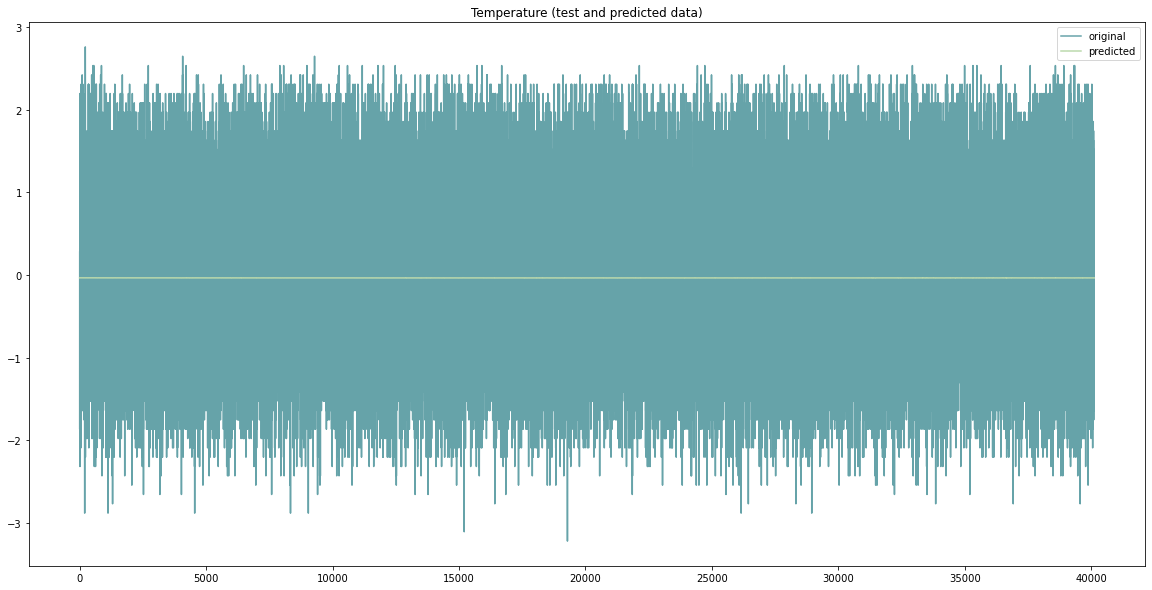

In [35]:
y_pred_temp = model_SVR1.predict(X_test_temp)
x_ax = range(len(y_test_temp))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_temp, label="original", color='#66a3a9')
plt.plot(x_ax, y_pred_temp, label="predicted", color='#bbd9ac')
plt.title("Temperature (test and predicted data)")
plt.legend()
plt.show()

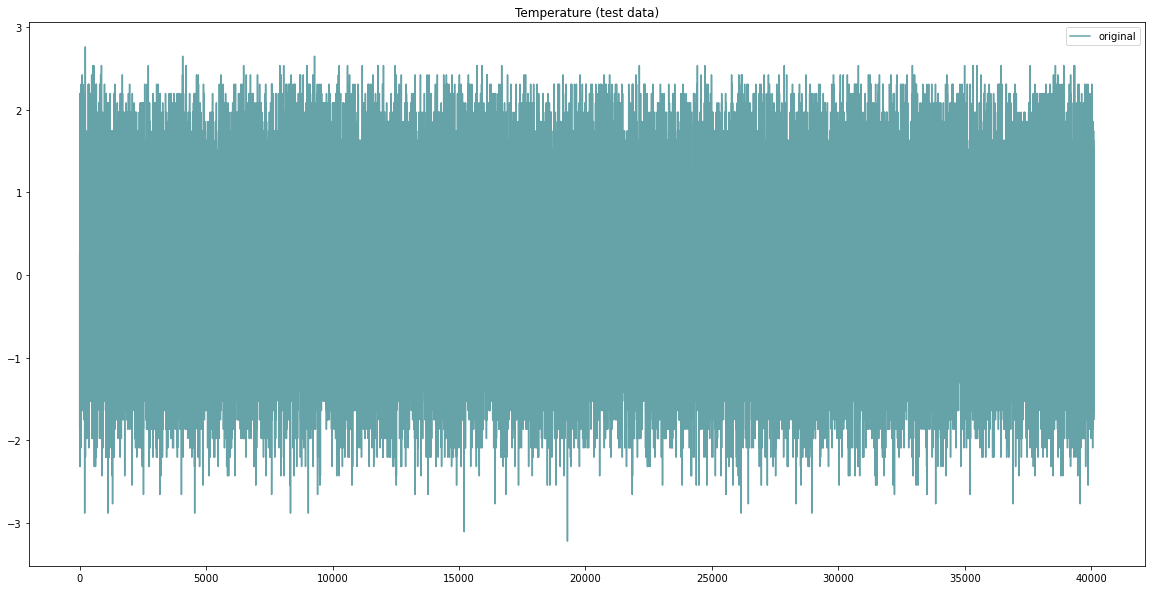

In [37]:
x_ax = range(len(y_test_temp))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_temp, label="original", color='#66a3a9')
plt.title("Temperature (test data)")
plt.legend()
plt.show()

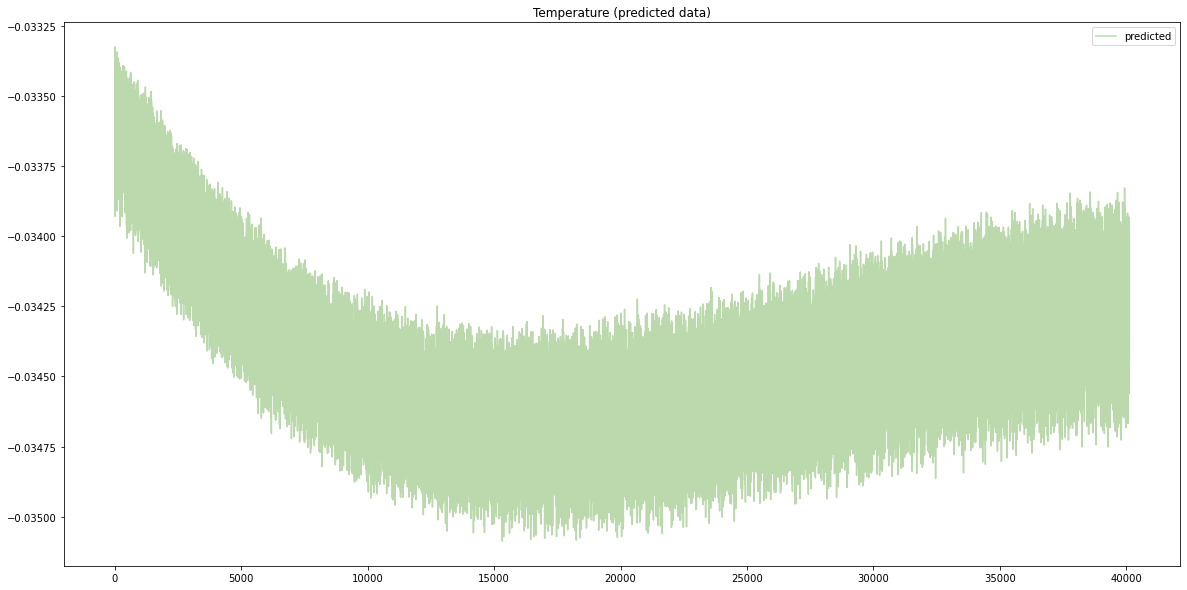

In [38]:
x_ax = range(len(y_test_temp))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_pred_temp, label="predicted", color='#bbd9ac')
plt.title("Temperature (predicted data)")
plt.legend()
plt.show()

# Second: Predict the wind

In [16]:
# The column that we will predict
target = "wind"

X_train_wind = train.drop(target, axis=1) # features
y_train_wind = train[target] # target

X_test_wind = test.drop(target, axis=1) # features
y_test_wind = test[target] # target

# KNN Model

In [40]:
# define the model
model_wind_KNN1 = KNeighborsRegressor()
model_wind_KNN1.fit(X_train_wind, y_train_wind)
# predict the wind
preds_wind_KNN1 = model_wind_KNN1.predict(X_train_wind) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_wind, preds_wind_KNN1))
print ("Testing MAE",  mean_absolute_error(y_test_wind, model_wind_KNN1.predict(X_test_wind)))

Training MAE 0.6741032666377162
Testing MAE 0.8278932001210817


In [41]:
mae_val = [] #to store mae values for different k
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_wind, y_train_wind)  #fit the model
    pred = model.predict(X_test_wind) # make prediction on test set
    error = mean_absolute_error(y_test_wind,pred) 
    mae_val.append(error) # store mae values
    print('mae value for k= ' , K , 'is:', error) 

mae value for k=  1 is: 1.0333052748244622
mae value for k=  2 is: 0.9090563295326244
mae value for k=  3 is: 0.8648683152591572
mae value for k=  4 is: 0.8423618415410979
mae value for k=  5 is: 0.8278932001210817
mae value for k=  6 is: 0.8220990335248083
mae value for k=  7 is: 0.8182895810930046
mae value for k=  8 is: 0.8159296676917032
mae value for k=  9 is: 0.8137821885930503
mae value for k=  10 is: 0.8129646262947829
mae value for k=  11 is: 0.8120448654599287
mae value for k=  12 is: 0.811353218725243
mae value for k=  13 is: 0.8103879006562958
mae value for k=  14 is: 0.8102212078180889
mae value for k=  15 is: 0.8093388282080788
mae value for k=  16 is: 0.8091055617957224
mae value for k=  17 is: 0.8088363273779853
mae value for k=  18 is: 0.8087382298446371
mae value for k=  19 is: 0.8087205885970752
mae value for k=  20 is: 0.8082392032632479


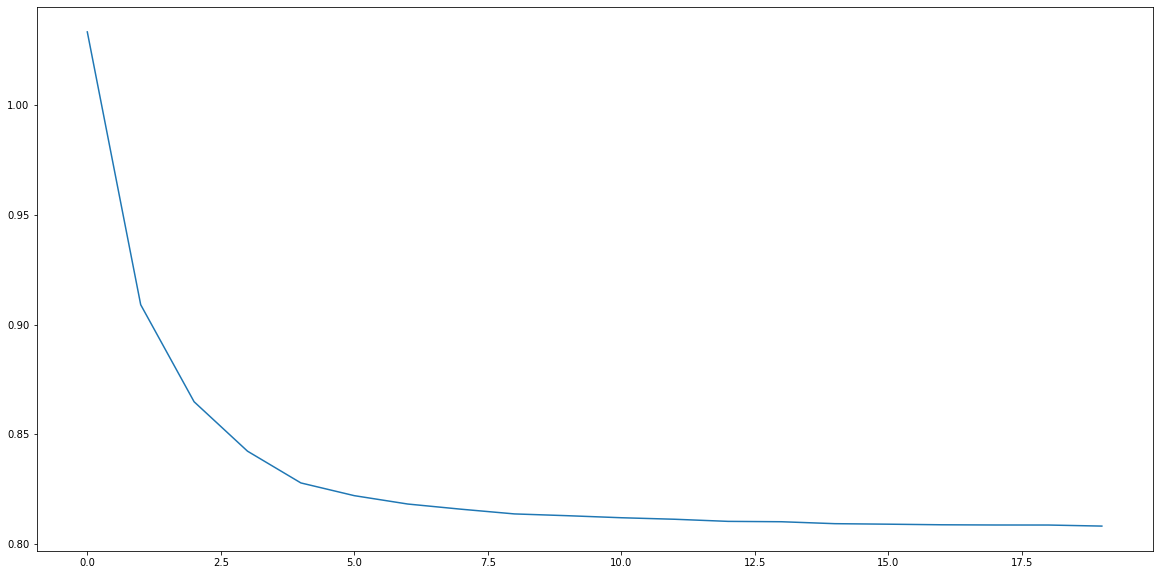

In [42]:
# plotting the mae values against k values
plt.figure(figsize = (20 , 10))
curve = pd.DataFrame(mae_val) # elbow curve 
plt.plot(curve)
plt.show()

In [43]:
# define the model
model_wind_KNN2 = KNeighborsRegressor(n_neighbors = 20)
model_wind_KNN2.fit(X_train_wind, y_train_wind)
# predict the wind
preds_wind_KNN2 = model_wind_KNN2.predict(X_train_wind) 
y_pred_wind = model_wind_KNN2.predict(X_test_wind)
# evaluate the model
print ("Training MAE",mean_absolute_error(y_train_wind, preds_wind_KNN2))
print ("Testing MAE", mean_absolute_error(y_test_wind, y_pred_wind))

Training MAE 0.7669785594431114
Testing MAE 0.8082392032632479


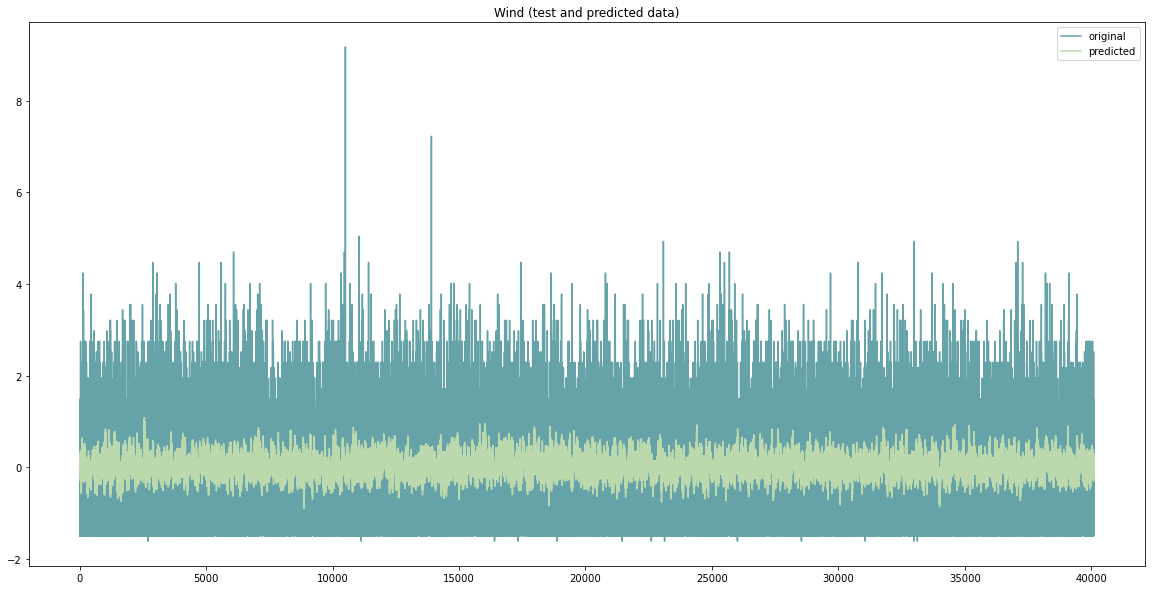

In [45]:
x_ax = range(len(y_test_wind))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_wind, label="original", color='#66a3a9')
plt.plot(x_ax, y_pred_wind, label="predicted", color='#bbd9ac')
plt.title("Wind (test and predicted data)")
plt.legend()
plt.show()

# XGBoost Model

In [46]:
# define the model
model_wind_XGB = XGBRegressor()
model_wind_XGB.fit(X_train_wind, y_train_wind)
# predict the wind
preds_wind_XGB = model_wind_XGB.predict(X_train_wind) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_wind, preds_wind_XGB))
y_pred_wind = model_wind_XGB.predict(X_test_wind)
print ("Testing MAE", mean_absolute_error(y_test_wind, y_pred_wind))

Training MAE 0.556308128370541
Testing MAE 0.5789136345616718


In [17]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror'] }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [18]:
hyperParameterTuning(X_train_wind, y_train_wind)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 130.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 259.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 433.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 537.0min finished


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [20]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.1,
        max_depth = 10,
        min_child_weight = 1,
        n_estimators = 500,
        subsample = 0.7)

xgb_model.fit(X_train_wind, y_train_wind)
# predict the temperature
preds_XGB = xgb_model.predict(X_train_wind) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_wind, preds_XGB))
print ("Testing MAE", mean_absolute_error(y_test_wind, xgb_model.predict(X_test_wind)))

Training MAE 0.3146914972487619
Testing MAE 0.5017607233101213


# SVM Model

In [48]:
# define the model
model_wind_SVR1 = SVR(C=1.0, epsilon =0.2)
model_wind_SVR1.fit(X_train_wind, y_train_wind)
# predict the wind
preds_wind_SVR1 = model_wind_SVR1.predict(X_train_wind) 
# evaluate the model
print ("Training MAE", mean_absolute_error(y_train_wind, preds_wind_SVR1))
y_pred_wind = model_wind_SVR1.predict(X_test_wind)
print ("Testing MAE",  mean_absolute_error(y_test_wind, y_pred_wind))

Training MAE 0.7876476445464817
Testing MAE 0.7872557828570401


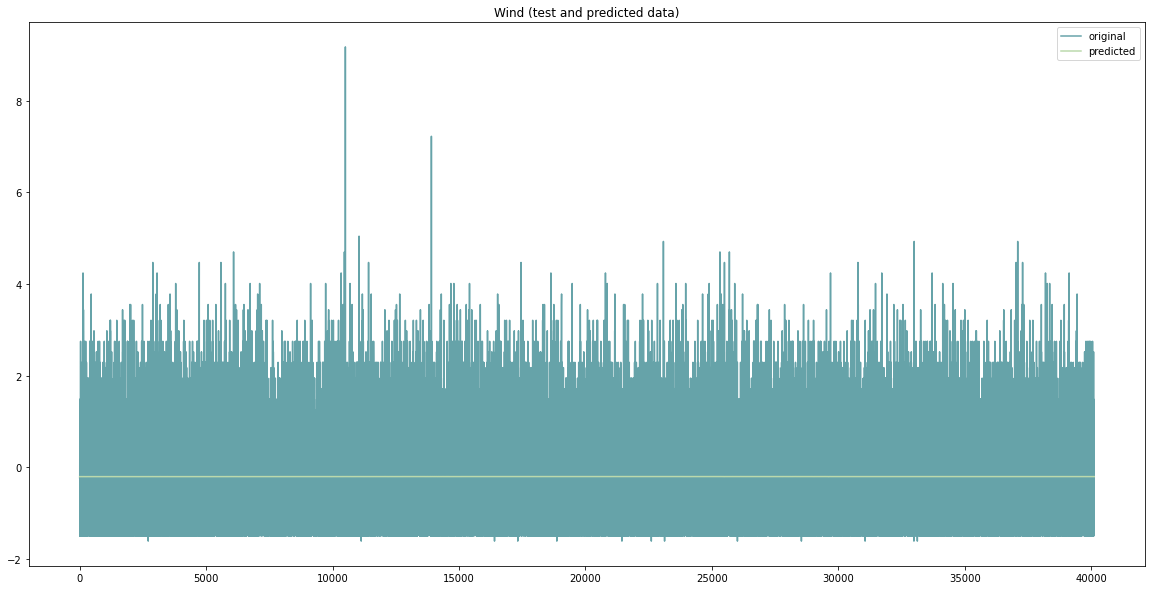

In [49]:
x_ax = range(len(y_test_wind))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_wind, label="original", color='#66a3a9')
plt.plot(x_ax, y_pred_wind, label="predicted", color='#bbd9ac')
plt.title("Wind (test and predicted data)")
plt.legend()
plt.show()

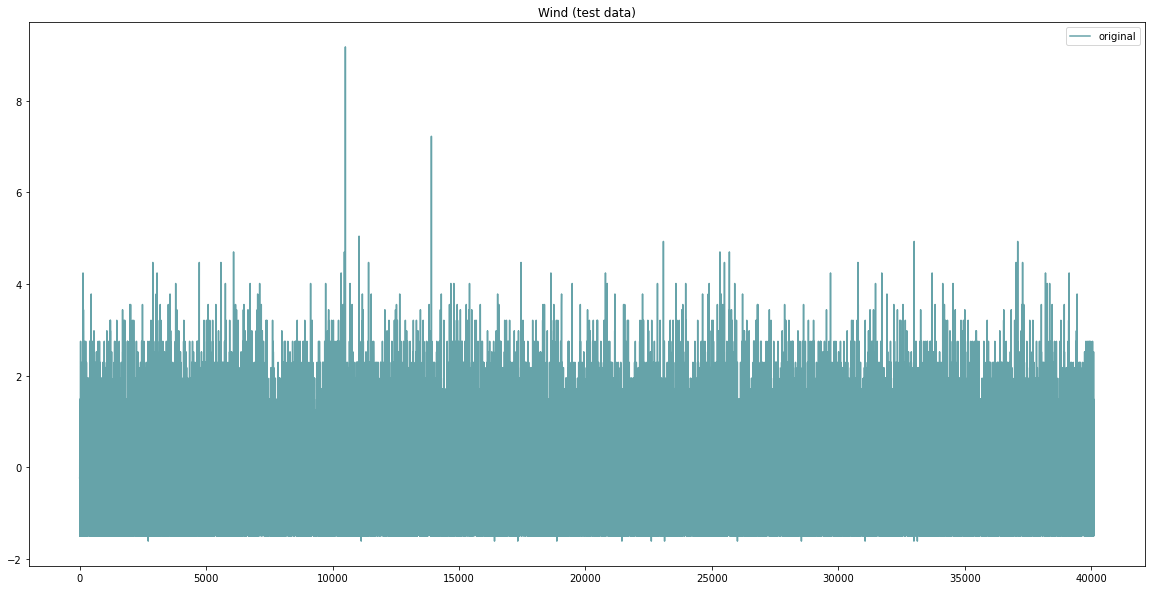

In [50]:
x_ax = range(len(y_test_wind))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_test_wind, label="original", color='#66a3a9')
plt.title("Wind (test data)")
plt.legend()
plt.show()

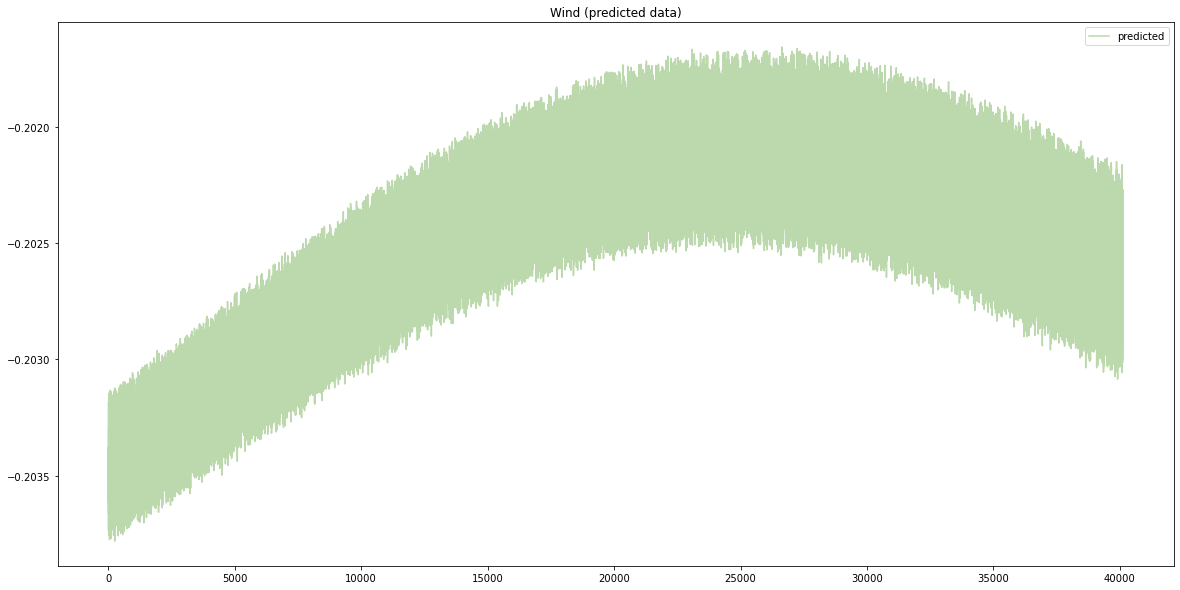

In [51]:
x_ax = range(len(y_test_wind))
plt.figure(figsize = (20 , 10))
plt.plot(x_ax, y_pred_wind, label="predicted", color='#bbd9ac')
plt.title("Wind (predicted data)")
plt.legend()
plt.show()